### Advanced Stock Pattern Prediction using LSTM with the Attention Mechanism in TensorFlow

In [1]:
!pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq
!pip install mplfinance -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.15.0


### Data Preprocessing and Preparation

In [3]:
# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

# Display the first few rows of the dataframe
aapl_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059418,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349121,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925652,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582657,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750244,132079200


In [4]:
# Checking for missing values
aapl_data.isnull().sum()

# Filling missing values, if any
aapl_data.fillna(method='ffill', inplace=True)

### Normalization

In [5]:
# Applying min-max scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))

### Creating Sequences

LSTM models require input to be in a sequence format

In [6]:
# Defining sequence length

X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])

### Train-Test Split

In [7]:
# Defining Split Ratio: Typically, 80% of data is used for training and 20% for testing.

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Reshaping Data for LSTM

In [8]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Building the LSTM with Attention Model

In [9]:
# Creating LSTM Layers

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

In [10]:
# Integrating the Attention Mechanism: Enhance the model’s ability to focus on relevant time steps

# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1)))
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

# Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

In [11]:
# Optimizing the Model: To enhance the model’s performance and reduce the risk of overfitting

from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

**Dropout** helps in preventing overfitting by randomly setting a fraction of the input units to 0 at each update during training, and **Batch Normalization** stabilizes the learning process.

### Model Compilation

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

It’s beneficial to view the summary of the model to understand its structure and number of parameters.

In [13]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 permute (Permute)           (None, 50, 60)            0         
                                                                 
 reshape (Reshape)           (None, 50, 60)            0         
                                                                 
 permute_1 (Permute)         (None, 60, 50)            0         
                                                                 
 reshape_1 (Reshape)         (None, 60, 50)            0         
                                                                 
 flatten (Flatten)           (None, 3000)              0

### Training the Model

In [14]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 9s 189ms/step - loss: 0.6559 - val_loss: 0.3719
Epoch 2/100
25/25 [==============================] - 2s 82ms/step - loss: 0.2814 - val_loss: 0.3510
Epoch 3/100
25/25 [==============================] - 1s 60ms/step - loss: 0.2471 - val_loss: 0.3203
Epoch 4/100
25/25 [==============================] - 1s 59ms/step - loss: 0.2266 - val_loss: 0.2964
Epoch 5/100
25/25 [==============================] - 1s 59ms/step - loss: 0.2065 - val_loss: 0.2700
Epoch 6/100
25/25 [==============================] - 1s 60ms/step - loss: 0.1884 - val_loss: 0.2472
Epoch 7/100
25/25 [==============================] - 1s 59ms/step - loss: 0.1675 - val_loss: 0.2294
Epoch 8/100
25/25 [==============================] - 2s 62ms/step - loss: 0.1511 - val_loss: 0.2053
Epoch 9/100
25/25 [==============================] - 2s 89ms/step - loss: 0.1378 - val_loss: 0.1839
Epoch 10/100
25/25 [==============================] - 2s 64ms/step - loss: 0.1206 - val_loss: 0.168

### Overfitting and How to Avoid It

**Overfitting** occurs when a model learns patterns specific to the training data, which do not generalize to new data. Here are ways to avoid overfitting:

- **Validation Set**: Using a validation set (as we did in the training code) helps in monitoring the model’s performance on unseen data.

- **Early Stopping**: This technique stops training when the model’s performance on the validation set starts to degrade. Implementing early stopping in Keras is straightforward:

In [15]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
25/25 [==============================] - 2s 93ms/step - loss: 0.0095 - val_loss: 0.0058
Epoch 2/100
25/25 [==============================] - 2s 89ms/step - loss: 0.0101 - val_loss: 0.0083
Epoch 3/100
25/25 [==============================] - 2s 81ms/step - loss: 0.0109 - val_loss: 0.0147
Epoch 4/100
25/25 [==============================] - 1s 60ms/step - loss: 0.0168 - val_loss: 0.0030
Epoch 5/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0169 - val_loss: 0.0012
Epoch 6/100
25/25 [==============================] - 1s 60ms/step - loss: 0.0131 - val_loss: 0.0025
Epoch 7/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0075 - val_loss: 0.0012
Epoch 8/100
25/25 [==============================] - 2s 73ms/step - loss: 0.0099 - val_loss: 0.0031
Epoch 9/100
25/25 [==============================] - 2s 85ms/step - loss: 0.0091 - val_loss: 0.0020
Epoch 10/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0112 - val_loss: 8.4567

**Regularization Techniques**: Techniques like Dropout and Batch Normalization, which are already included in our model, also help in reducing overfitting.

In [16]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Callback to save the model periodically
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
25/25 [==============================] - 2s 64ms/step - loss: 0.0114 - val_loss: 8.9355e-04 - lr: 0.0010
Epoch 2/100
 2/25 [=>............................] - ETA: 1s - loss: 0.0130

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 2s 60ms/step - loss: 0.0100 - val_loss: 9.2540e-04 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 2s 85ms/step - loss: 0.0082 - val_loss: 0.0012 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0094 - val_loss: 0.0090 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0125 - val_loss: 0.0097 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 2s 63ms/step - loss: 0.0123 - val_loss: 0.0034 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 1s 60ms/step - loss: 0.0086 - val_loss: 0.0011 - lr: 1.0000e-04
Epoch 8/100
25/25 [==============================] - 2s 62ms/step - loss: 0.0080 - val_loss: 7.8728e-04 - lr: 1.0000e-04
Epoch 9/100
25/25 [==============================] - 1s 60ms/step - loss: 0.0095 - val_loss: 7.9568e-04 - lr: 1.0000e-04
Epoch 10/100
25/25 [==============================] - 1s 60ms/step - loss: 0.0098 - 

### Evaluating Model Performance

In [17]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

6/6 [==============================] - 0s 19ms/step - loss: 0.0081
Test Loss:  0.008054234087467194


### Performance Metrics

In addition to the loss, other metrics can provide more insights into the model's performance. For regression tasks like ours, common metrics include:

- **Mean Absolute Error (MAE)**: This measures the average magnitude of the errors in a set of predictions, without considering their direction.

- **Root Mean Square Error (RMSE)**: This is the square root of the average of squared differences between prediction and actual observation.

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

6/6 [==============================] - 1s 17ms/step
Mean Absolute Error:  0.08616784843495262
Root Mean Square Error:  0.08974538620536844


Both **MAE** and **RMSE** are measures of prediction accuracy for a regression model.

**MAE** measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

**RMSE** is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation. The RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable.

### Predicting the Next 4 Candles

In [19]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetching the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 candles
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_stock_price)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 32ms/step
Predicted Stock Prices for the next 4 days:  [[171.8147]]


In [20]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step
Predicted Stock Prices for the next 4 days:  [171.8147, 173.0913, 174.28737, 175.25786]


### Visualization of Predictions

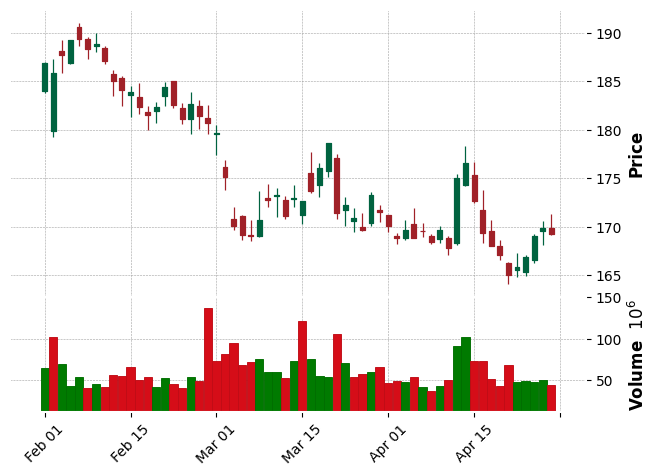

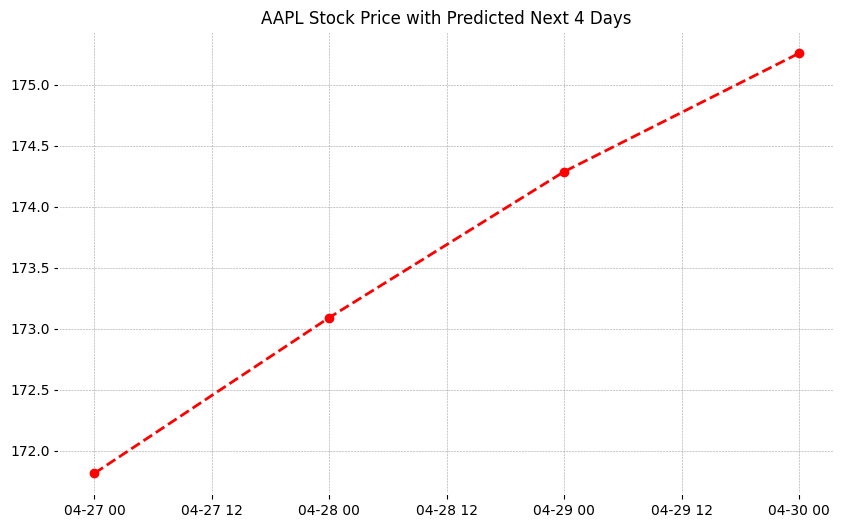

In [21]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AAPL Stock Price with Predicted Next 4 Days")
plt.show()


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 39ms/step


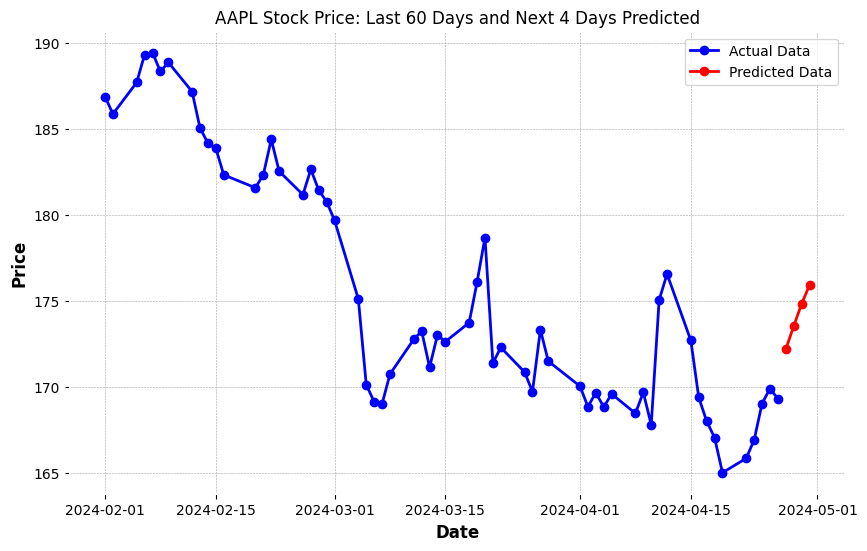

In [22]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Key points include:

- LSTM’s ability to capture long-term dependencies in time-series data.
- The added advantage of the attention mechanism in focusing on relevant data points.
- The detailed process of building, training, and evaluating the LSTM model.


While LSTM models with attention are powerful, they have limitations:

- The assumption that historical patterns will repeat in similar ways can be problematic, especially in volatile markets.
- External factors like market news and global events, not captured in historical price data, can significantly influence stock prices.